In [16]:
%matplotlib inline

In [17]:
import numpy as np
import pandas as pd
import pickle as pkl
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from matplotlib import pyplot as plt
from datetime import timedelta, datetime
from joblib import delayed, Parallel
from copy import copy

from core import  do_simulation
from helpers import Params, T, get_T1_and_T2, R0, plot_total, DATE_FORMAT, total_to_csv, save_to_json, save_bundle

from const import STATE, COLORS, NUM_STATES,  STATES


In [18]:
p0_time = pkl.load(open('output/p0_time.pkl', 'rb'))
lockdown_time = T('23/01/2020')
params_before = pkl.load(
    open('output/params_before_lockdown.pkl', 'rb')
)

params_after = pkl.load(
    open('output/params_after_lockdown.pkl', 'rb')
)

bed_info = pkl.load(open('data/bed_info.pkl', 'rb'))

In [19]:
days_to_p0 = (lockdown_time - p0_time).days
# print('lockdown date',  assumed_ld_date)
params = Params(
    total_population=params_before.total_population,
    initial_num_E=params_before.initial_num_E,
    initial_num_I=params_before.initial_num_I,
    initial_num_M=params_before.initial_num_M,    
    mu_ei=params_after.mu_ei,
    mu_mo=params_after.mu_mo,
    k_days=params_after.k_days,
    x0_pt=params_after.x0_pt,  
    alpha=[(0, params_before.alpha), (days_to_p0, params_after.alpha)],
    beta=[(0, params_before.beta), (days_to_p0, params_after.beta)],
    stages=[days_to_p0]
)

In [20]:
def one_run(bed_number_factor, total_days=360):
    updated_bed_info = [(t, n*bed_number_factor) for (t, n) in bed_info]
    total, delta, increase, trans, stats = do_simulation(total_days, updated_bed_info, params, p0_time=p0_time, verbose=0)    
    bundle = [total, delta, increase, trans]
    return bed_number_factor, bundle, stats

In [21]:
total_days = 360

In [22]:
rows = Parallel(n_jobs=-1)(
    delayed(one_run)(factor, total_days)
    for  factor in np.arange(0.5, 3.1, step=0.5)
)

0.5
['28/11/19' '08/02/20' '20/04/20' '01/07/20' '11/09/20' '22/11/20']
1.0
['28/11/19' '08/02/20' '20/04/20' '01/07/20' '11/09/20' '22/11/20']
1.5
['28/11/19' '08/02/20' '20/04/20' '01/07/20' '11/09/20' '22/11/20']
2.0
['28/11/19' '08/02/20' '20/04/20' '01/07/20' '11/09/20' '22/11/20']
2.5
['28/11/19' '08/02/20' '20/04/20' '01/07/20' '11/09/20' '22/11/20']
3.0
['28/11/19' '08/02/20' '20/04/20' '01/07/20' '11/09/20' '22/11/20']


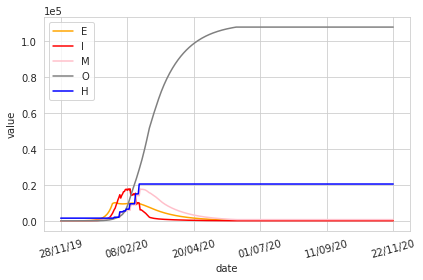

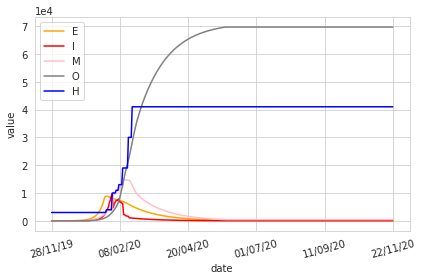

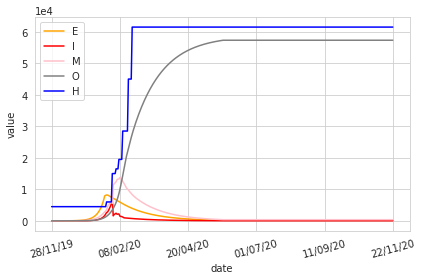

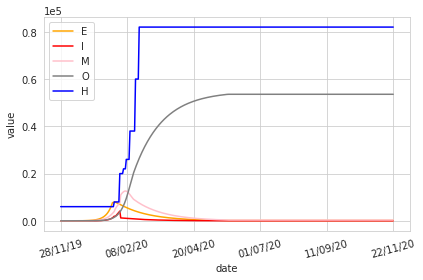

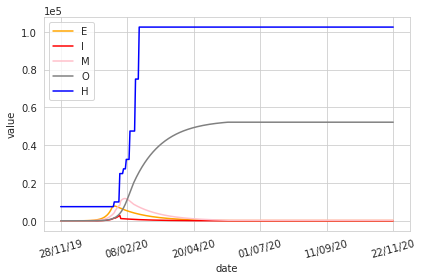

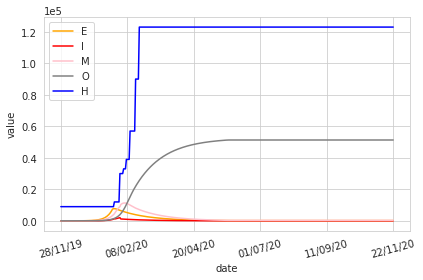

In [23]:
for factor, bundle, stats in rows:
    print(factor)
    fig, ax = plot_total(bundle[0], p0_time,  total_days)
    fig.savefig(f'figs/bed-number/{factor}.pdf')
    
    save_bundle(bundle, p0_time, total_days, f'output/tbl/bed-number/{factor}/')
    save_to_json(stats, f'output/tbl/bed-number/{factor}/stats.txt')    